This notebook is performing the Exploratory Data Analysis(EDA) and train the data on the basic model for the [Human Protein Atlas Image Classification](https://www.kaggle.com/c/human-protein-atlas-image-classification) challange. 
Link to this Notebook on Kaggle: [Link](https://www.kaggle.com/smehta12/eda-and-base-modeling)

It uses the CV2 library to perfrom various tasks of the EDA on images. Also, is builds the basic sequential model using the Keras.

In [1]:
import time

start_time = time.time()

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import cv2
import gc
import random

In [2]:
root_dir='/home/shalin/my_projects/protein_atlas' #"../input"#r"C:\my_projects\protein_identification"
train_dir=os.path.join(root_dir, "train")
test_dir=os.path.join(root_dir, "test")
train_csv_path=os.path.join(root_dir,"train.csv")

In [3]:
ORIG_IMAGE_SIZE=512

In [4]:
# read the training csv
train_csv = pd.read_csv(train_csv_path)
print(train_csv.shape)
train_csv.head()

(31072, 2)


Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18

In [5]:
class_names = {
    0:"Nucleoplasm",
    1:"Nuclear membrane", 
    2:"Nucleoli", 
    3:"Nucleoli fibrillar center", 
    4:"Nuclear speckles", 
    5:"Nuclear bodies", 
    6:"Endoplasmic reticulum", 
    7:"Golgi apparatus", 
    8:"Peroxisomes", 
    9:"Endosomes", 
    10:"Lysosomes", 
    11:"Intermediate filaments", 
    12:"Actin filaments", 
    13:"Focal adhesion sites", 
    14:"Microtubules", 
    15:"Microtubule ends", 
    16:"Cytokinetic bridge", 
    17:"Mitotic spindle", 
    18:"Microtubule organizing center", 
    19:"Centrosome", 
    20:"Lipid droplets", 
    21:"Plasma membrane", 
    22:"Cell junctions", 
    23:"Mitochondria", 
    24:"Aggresome", 
    25:"Cytosol", 
    26:"Cytoplasmic bodies", 
    27:"Rods & rings" 
}

## Let's take a look at class stats

In [6]:
# split the targets in train csv

def split_classes(row):
    for cls_num in row["Target"].split():
        train_csv.loc[row.name, class_names[int(cls_num)]]=1

for cls_num, cls_name in class_names.items():
    train_csv[cls_name]=0

# train_csv["splitted"] = train_csv["Target"].apply(lambda x: i+1 for i in x.split())
train_csv.apply(split_classes, axis=1)
train_csv.head()

Id   Target  Nucleoplasm  \
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0            1   
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0            1   
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5            0   
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1            0   
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18            0   

   Nuclear membrane  Nucleoli  Nucleoli fibrillar center  Nuclear speckles  \
0                 0         0                          0                 0   
1                 1         1                          0                 0   
2                 0         0                          0                 0   
3                 1         0                          0                 0   
4                 0         0                          0                 0   

   Nuclear bodies  Endoplasmic reticulum  Golgi apparatus      ...       \
0               0                      0                0      ...        
1               0                      0                1      ...        
2               1                      0                0      ...        
3               0                      0                0      ...        
4               0                      0                0      ...        

   Microtubule organizing center  Centrosome  Lipid droplets  Plasma membrane  \
0                              0           0               0                0   
1                              0           0               0                0   
2                              0           0               0                0   
3                              0           0               0                0   
4                              1           0               0                0   

   Cell junctions  Mitochondria  Aggresome  Cytosol  Cytoplasmic bodies  \
0               0             0          0        0                   0   
1               0             0          0        0                   0   
2               0             0          0        0                   0   
3               0             0          0        0                   0   
4               0             0          0        0                   0   

   Rods & rings  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 30 columns]

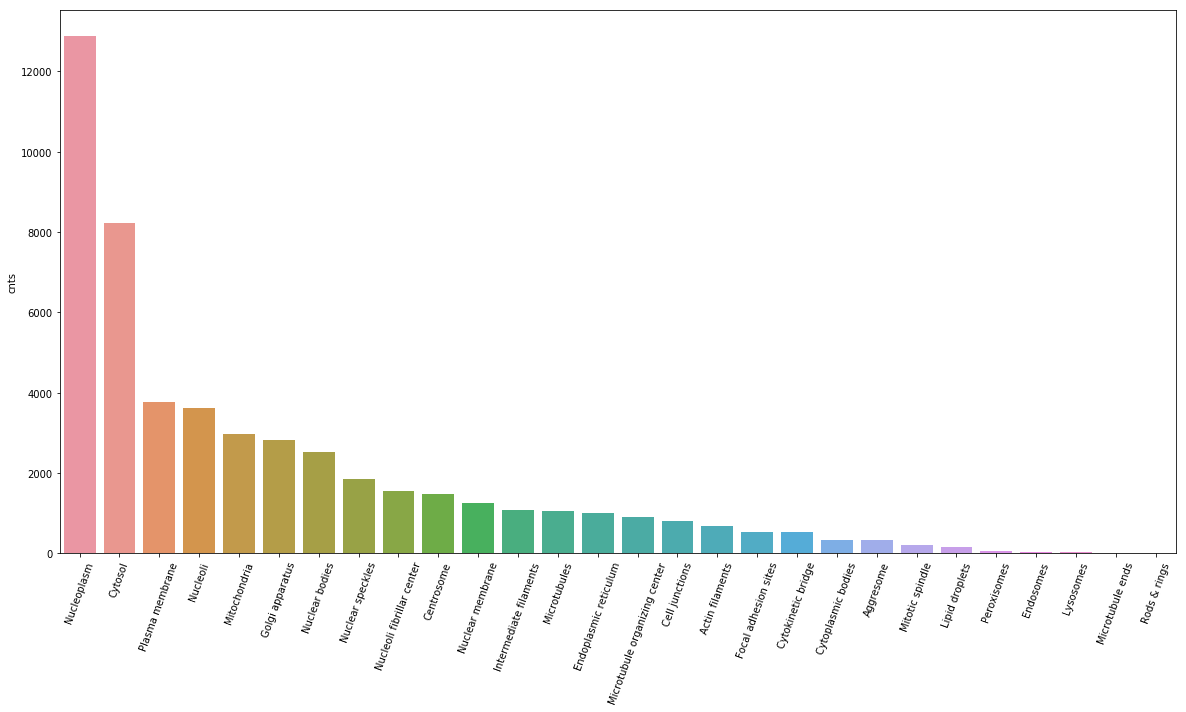

In [7]:
counts=train_csv[list(class_names.values())].sum().sort_values(ascending=False)
counts = counts.to_frame("cnts")
plt.figure(figsize=(20, 10))
sns.barplot(counts.index, counts.cnts)
plt.xticks(rotation=70)
plt.show()

In [8]:
counts

cnts
Nucleoplasm                    12885
Cytosol                         8228
Plasma membrane                 3777
Nucleoli                        3621
Mitochondria                    2965
Golgi apparatus                 2822
Nuclear bodies                  2513
Nuclear speckles                1858
Nucleoli fibrillar center       1561
Centrosome                      1482
Nuclear membrane                1254
Intermediate filaments          1093
Microtubules                    1066
Endoplasmic reticulum           1008
Microtubule organizing center    902
Cell junctions                   802
Actin filaments                  688
Focal adhesion sites             537
Cytokinetic bridge               530
Cytoplasmic bodies               328
Aggresome                        322
Mitotic spindle                  210
Lipid droplets                   172
Peroxisomes                       53
Endosomes                         45
Lysosomes                         28
Microtubule ends                  21
Rods & rings                      11

Based on the above figure the `Nucleoplasm` has the highest samples. Whereas last few labels in the above plot has very low samples. So the dataset is imbalanced. This should be take into account while training a model. 

### Correlations and co-occurences of Labels

Now we can try to see which labels has highest correlation and co-occurence with each other. Later we will try to see using images to find why it happned? Is it due to the structure of the proteins? 

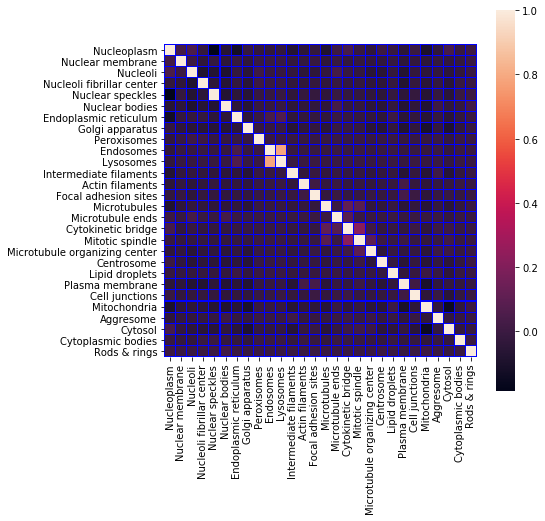

In [9]:
corr=train_csv[list(class_names.values())].corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corr, linewidths=0.05, linecolor='b', square=True)
plt.show()

In the above diagram it looks like the `Endosomes` and the `Lysosomes` are highly correlated. This is not further suprising since they look very similiar. Plus by looking into the train_csv Lysosomes are always occur with the Endosomes. There's no single Lysosomes record. There's also some correlation between `Cytokinetic bridge` and `Mitotic spindle`.

In [10]:
#for labels in train_csv.values():

co_occur_map = pd.DataFrame(index=list(class_names.values()), columns=list(class_names.values()))
co_occur_map=co_occur_map.fillna(0)

def find_create_map(row):
    classes = row.split()
    for r in classes:
        for c in classes:
            co_occur_map.loc[class_names[int(r)], class_names[int(c)]] += 1

train_csv["Target"].apply(find_create_map)
co_occur_map.head()

Nucleoplasm  Nuclear membrane  Nucleoli  \
Nucleoplasm                      12885               600      1735   
Nuclear membrane                   600              1254       147   
Nucleoli                          1735               147      3621   
Nucleoli fibrillar center          571                19         4   
Nuclear speckles                    97                52        48   

                           Nucleoli fibrillar center  Nuclear speckles  \
Nucleoplasm                                      571                97   
Nuclear membrane                                  19                52   
Nucleoli                                           4                48   
Nucleoli fibrillar center                       1561                23   
Nuclear speckles                                  23              1858   

                           Nuclear bodies  Endoplasmic reticulum  \
Nucleoplasm                           806                     89   
Nuclear membrane                       39                     21   
Nucleoli                               59                     79   
Nucleoli fibrillar center              14                     24   
Nuclear speckles                        5                      2   

                           Golgi apparatus  Peroxisomes  Endosomes  \
Nucleoplasm                           1092            5          0   
Nuclear membrane                        56            0          0   
Nucleoli                               189           11          0   
Nucleoli fibrillar center               40            4          0   
Nuclear speckles                        42            0          0   

                               ...       Microtubule organizing center  \
Nucleoplasm                    ...                                 279   
Nuclear membrane               ...                                  11   
Nucleoli                       ...                                  18   
Nucleoli fibrillar center      ...                                   5   
Nuclear speckles               ...                                  16   

                           Centrosome  Lipid droplets  Plasma membrane  \
Nucleoplasm                       614              58             1343   
Nuclear membrane                   19               0               76   
Nucleoli                           56               6              216   
Nucleoli fibrillar center          20               0               35   
Nuclear speckles                   16               2              135   

                           Cell junctions  Mitochondria  Aggresome  Cytosol  \
Nucleoplasm                           325           802         78     3631   
Nuclear membrane                        7            45          1      261   
Nucleoli                               52           226         12      782   
Nucleoli fibrillar center              16            51          3      272   
Nuclear speckles                       24            44          8      329   

                           Cytoplasmic bodies  Rods & rings  
Nucleoplasm                               115             7  
Nuclear membrane                            0             0  
Nucleoli                                   11             1  
Nucleoli fibrillar center                  12             0  
Nuclear speckles                           17             1  

[5 rows x 28 columns]

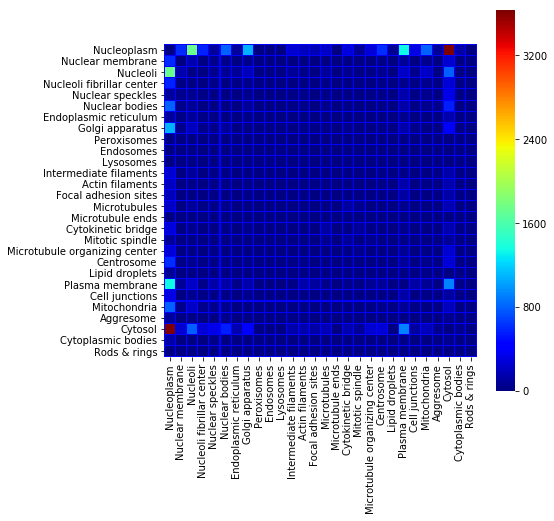

In [11]:
# making 0s to same classes so the map can be seen well
for cls in class_names.values():
    co_occur_map.loc[cls, cls]=0

plt.figure(figsize=(7, 7))
sns.heatmap(co_occur_map, cmap="jet", linewidths=0.05, linecolor='b', square=True)
plt.show()

Based on the above diagram we can see that few of the classes has high co-occurence. Most of them are with the `Nucleoplasm`. Probably because occurence of that is more than any other classes. We'll try to see it in images and find out what's the similarity.

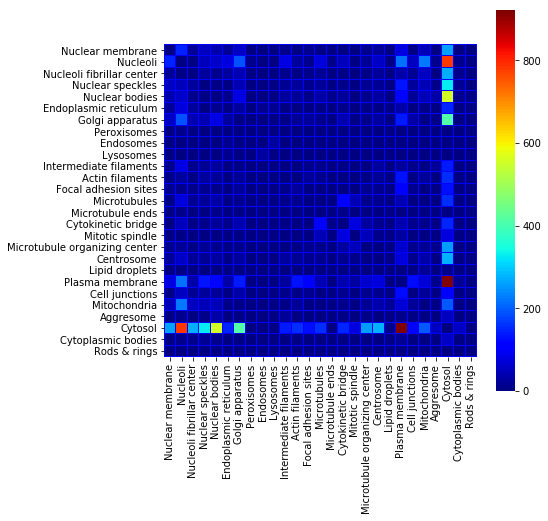

In [12]:
# If we remove the the Nucleoplasm then see which classes has more co-occurence.
co_map = co_occur_map.drop(index=["Nucleoplasm"])
co_map = co_map.drop(columns=["Nucleoplasm"])

plt.figure(figsize=(7, 7))
sns.heatmap(co_map, cmap="jet", linewidths=0.05, linecolor='b', square=True)
plt.show()

By looking at above figure we can see that the second highest class `Cytosol` has more co-occurence than other but it also reveals more co-occurence with some other classes like `nucleoli`, `Plasma membrance`, `Golgi apparatus` etc. All of these classes are in top 10 classes. So based on that we can conclude that it is very common to have co-occurences in this data. **So in our model we may need to emphasize on predicting multiple classes**

### EDA based on the images

Let's check the images for different classes, apply some image processing and try to find out some above questions in order to get some more understanding of the data. Which can help to build a good model.

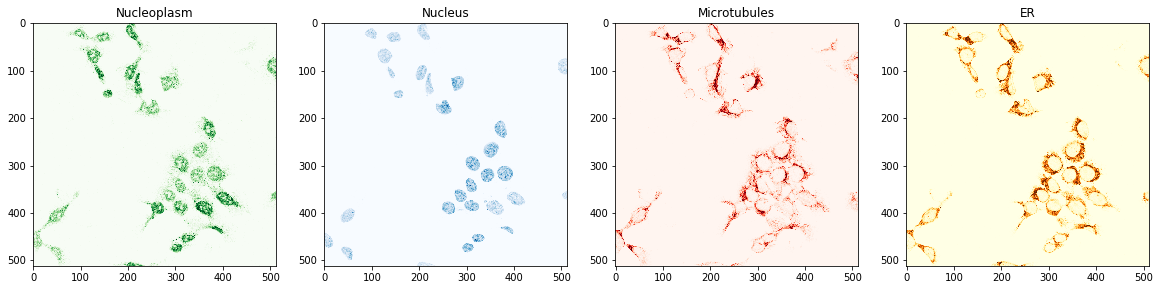

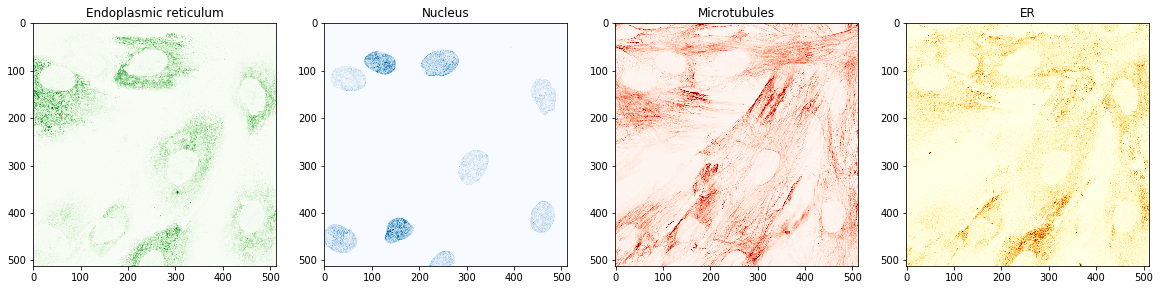

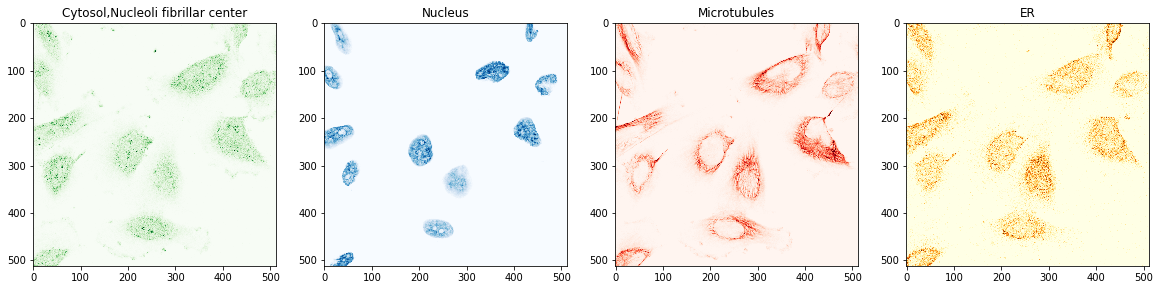

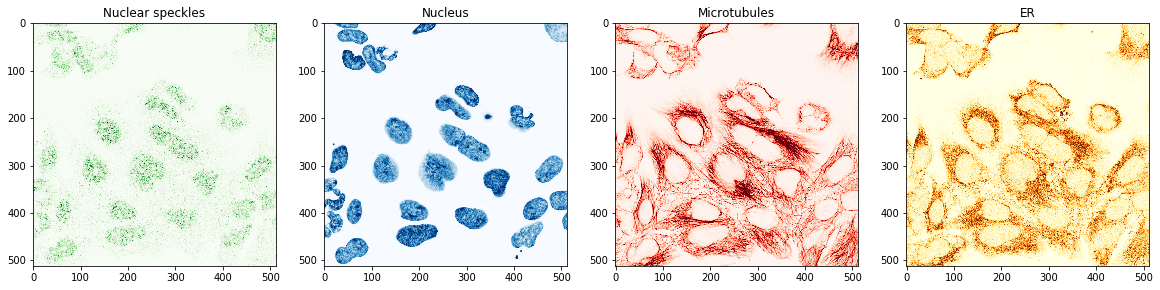

In [13]:
# show the random protein images

num_random = 4

colors = [ "_green.png", "_blue.png", "_red.png", "_yellow.png"]
cmaps =["Greens", "Blues", "Reds", "YlOrBr"]

rnd_imgs = random.sample(train_csv["Id"].values.tolist(), num_random)

for img in rnd_imgs:
    plt.figure(figsize=(20, 10))
    
    green_img_name = []
    classes = train_csv[train_csv["Id"]==img]["Target"].values.tolist()
    for cls in  classes[0].split():
        green_img_name.append(class_names[int(cls)])
    
    green_img_name = ",".join(green_img_name)
      
    
    for j, color in enumerate(colors):
        plt.subplot(1, 4, j+1)
        if j == 0:
            plt.title(green_img_name)
        if j == 1:
            plt.title("Nucleus")
        if j == 2:
            plt.title("Microtubules")
        if j == 3:
            plt.title("ER")
        plt.grid(False)
        image = cv2.imread(os.path.join(train_dir,img+color), 0)
        image.astype(float)
        plt.imshow(image, cmap=cmaps[j])
plt.show()

 **Lets further take a quick look at an overlay of the channels**

In [14]:
def display_combined_rgb_img(img):
    print(os.path.join(train_dir,img))
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    all_images = np.empty((512,512,4))
    for i, color in enumerate(['red', 'green', 'yellow', 'blue']):
        all_images[:,:,i] = plt.imread(os.path.join(train_dir,img+"_{}.png").format(color))

    # define transformation matrix
    # note that yellow is made usign red and green
    # but you can tune this color conversion yourself
    T = np.array([[1,0,1,0],[0,1,1,0],[0,0,0,1]])

    # convert to rgb
    rgb_image = np.matmul(all_images.reshape(-1, 4), np.transpose(T))
    rgb_image = rgb_image.reshape(all_images.shape[0], all_images.shape[0], 3)
    rgb_image = np.clip(rgb_image, 0, 1)

    # plot
    ax.imshow(rgb_image)
    ax.set(xticks=[], yticks=[])

    return rgb_image

/home/shalin/my_projects/protein_atlas/train/05551280-bba4-11e8-b2b9-ac1f6b6435d0


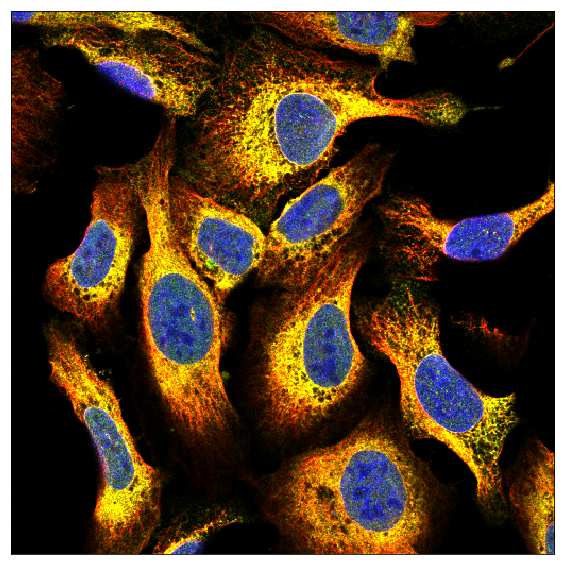

In [15]:
img=random.sample(train_csv.Id.values.tolist(), 1)[0]
display_combined_rgb_img(img)
plt.show()

/home/shalin/my_projects/protein_atlas/train/001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0


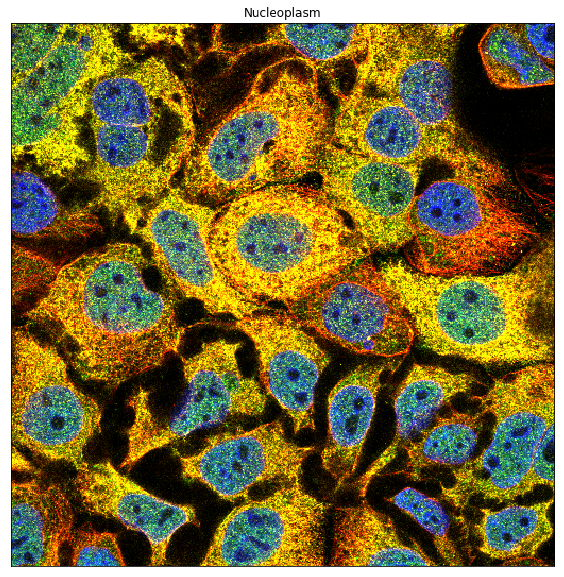

<Figure size 72x72 with 0 Axes>

/home/shalin/my_projects/protein_atlas/train/00383b44-bbbb-11e8-b2ba-ac1f6b6435d0


<Figure size 72x72 with 0 Axes>

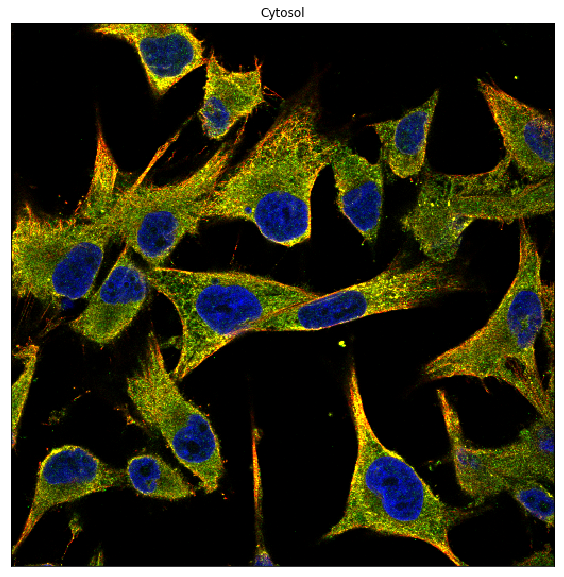

/home/shalin/my_projects/protein_atlas/train/004a2b84-bbc4-11e8-b2bc-ac1f6b6435d0


<Figure size 72x72 with 0 Axes>

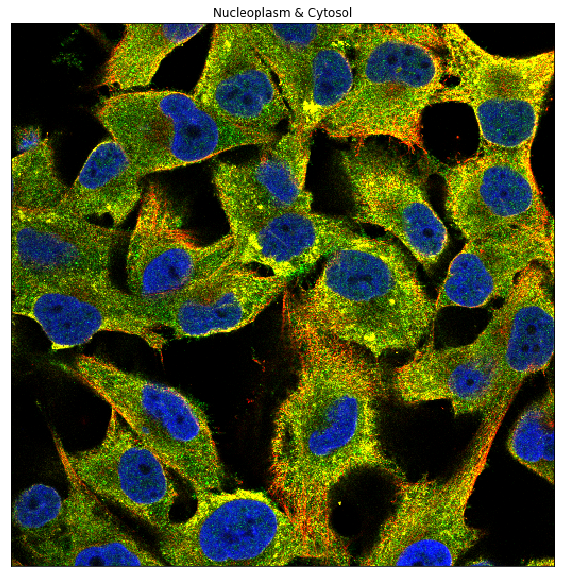

In [17]:
# let's see random image of Nucleoplasm and Cytosol to understand the co-occurence between those classes
fig_size=(1,1)

# get first image where there's only Nucleoplasm
nue=train_csv[train_csv.Target.isin(['0'])]
nue=nue.reset_index(drop=True).iloc[0]["Id"]
display_combined_rgb_img(nue)
plt.title("Nucleoplasm")
plt.figure(figsize=fig_size)
plt.show()

# get first image where there's only Cytosol
cyt=train_csv[train_csv.Target.isin(['25'])]
cyt=cyt.reset_index(drop=True).iloc[0]["Id"]
plt.figure(figsize=fig_size)
display_combined_rgb_img(cyt)
plt.title("Cytosol")
plt.show()

# get first image where there's both Nucleoplasm and Cytosol together
nue_cyt=train_csv.query('Nucleoplasm==1 & Cytosol==1')
nue_cyt=nue_cyt.reset_index(drop=True).iloc[1]["Id"]
plt.figure(figsize=fig_size)
display_combined_rgb_img(nue_cyt)
plt.title("Nucleoplasm & Cytosol")
plt.show()

By looking at above images, it seems like it will be hard to make any visual connection just by looking at the images. Also,this [Kaggle question](https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/68597#414634) indicates that no cell will show the similar pattern as another. Probably it requires domain knowledge to derive this type of conclusion. I don't have any domain knowledge in this area so I will leave the co-occurence topic here. I will try to come back if I find out some quick explnation.

### Cell Segmentation

By performaing the simple cell Segmentation it can give insight that what we should look at when developing the model to  classify the images.

Also, By looking at images above we saw that the amount and size of cells varies a lot and therefore the POI shows a great deal of variance. By using the simple segmentation it can be studied for the various types of image. Which can helpful to build the final model.

For the segmentation I took the reference of [this](https://www.kaggle.com/weegee/protein-where-art-thou) notebook

/home/shalin/my_projects/protein_atlas/train/f2df3a80-bba9-11e8-b2ba-ac1f6b6435d0


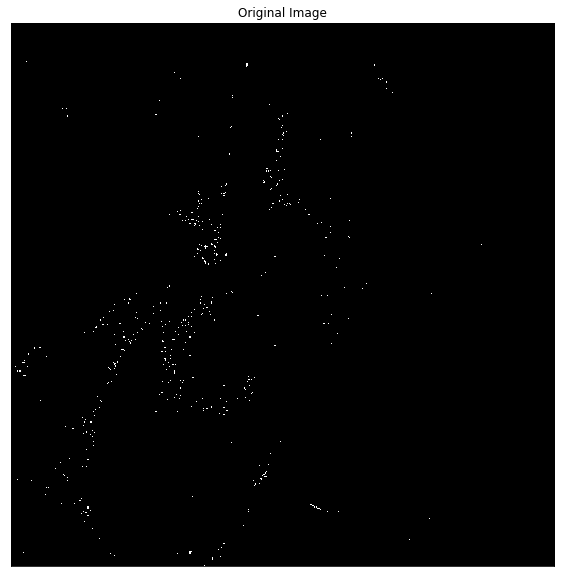

In [18]:
img=random.sample(train_csv.Id.values.tolist(), 1)[0]
rgb_image=display_combined_rgb_img(img)
#print(rgb_image.shape)
rgb_image=np.uint16(rgb_image)
gray_img=cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY) # converting due to thresholding should be applied on gray.


plt.title("Original Image")
plt.imshow(gray_img, cmap="gray")
plt.show()

Using above method the image doesn't show any details, so let's try another strategy. 

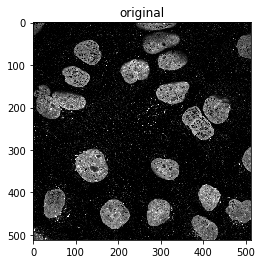

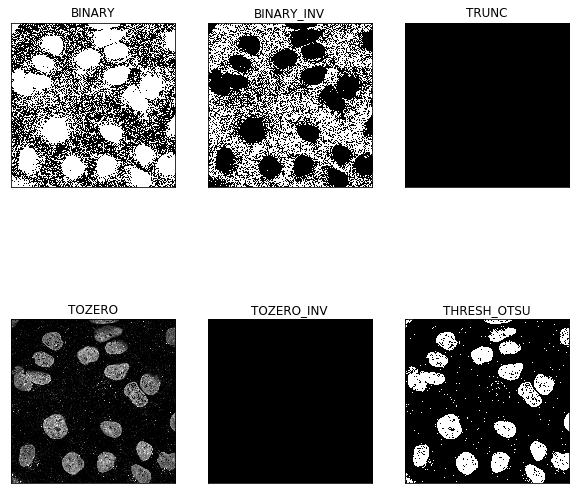

In [19]:
img=random.sample(train_csv.Id.values.tolist(), 1)[0]

poi = cv2.imread(os.path.join(train_dir,img+"_green.png"), 0)
nuc = cv2.imread(os.path.join(train_dir,img+"_blue.png"), 0)
mt = cv2.imread(os.path.join(train_dir,img+"_yellow.png"), 0)
er = cv2.imread(os.path.join(train_dir,img+"_red.png"), 0)
composit = cv2.add(poi,nuc, mt, er)
#composit = cv2.resize(composit, (256,256))

plt.figure()
plt.grid(False)
plt.title("original")
plt.imshow(composit, cmap="gray")
plt.show()


ret,thresh1 = cv2.threshold(composit,0,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(composit,0,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(composit,0,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(composit,0,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(composit,0,255,cv2.THRESH_TOZERO_INV)
ret,thresh6 = cv2.threshold(composit,0,255,cv2.THRESH_OTSU)

plt.figure(figsize=(10,10))
titles = ['BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV', 'THRESH_OTSU']
images = [thresh1, thresh2, thresh3, thresh4, thresh5, thresh6]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In all of above thrsholds the THRESH_OTSU works better than any other thresholds, so we'll use it for the further processing.

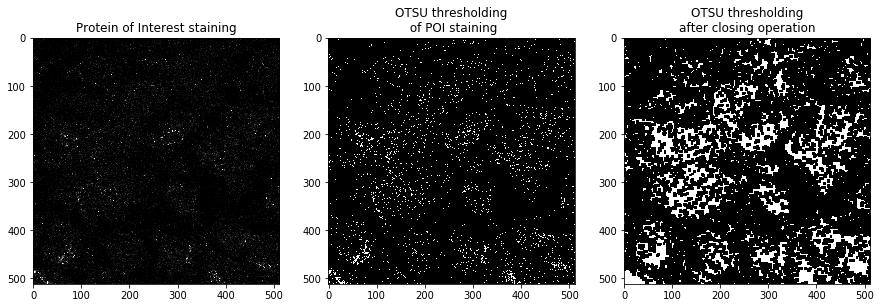

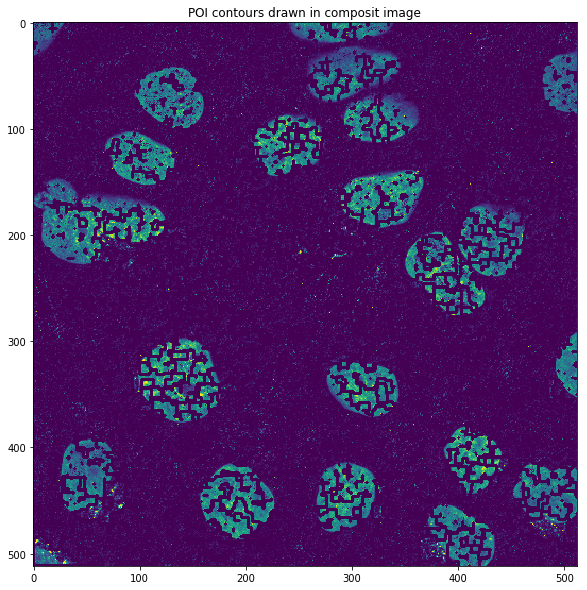

In [20]:
nuc = cv2.imread(os.path.join(train_dir,img+"_green.png"), 0)
#nuc = cv2.resize(nuc, (256,256))
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.grid(False)
plt.title("Protein of Interest staining")
plt.imshow(nuc, cmap='gray')

t, thresh = cv2.threshold(nuc, 0,255,cv2.THRESH_OTSU)

plt.subplot(132)
plt.grid(False)
plt.title("OTSU thresholding\n of POI staining")
plt.imshow(thresh, cmap="gray")

kernel = np.ones((6,6),np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.subplot(133)
plt.grid(False)
plt.title("OTSU thresholding\nafter closing operation")
plt.imshow(closing, cmap="gray")

im, contours,hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

t=cv2.drawContours(composit, contours, -1, (0,0,0), 2)

plt.figure(figsize=(10,10))
plt.grid(False)
plt.title("POI contours drawn in composit image")
plt.imshow(t)
plt.show()

By looking at the image above it shows some intersting structures. Those may be the protein of interest or some other particals. Based on this we can derieve that when the modeling will done it should look at this type of similar structure and in the inference it should point this type structures. Which matches the goal of this challange to do the localization of the samples.

## Modeling

Based on the description, the model shoule predict protein localization labels for each sample. There are in total 28 different labels present in the dataset. And as we saw before there can be multiple labels per image. So it is a multi label problem. In addition to that the data is imabalanced training data. So we need to find out a technique where the imabalanced classes don't affect in inference phase. 

According to description of the problem, the green filter should be used to predict the label, and the other filters are used as references. So below, we'll try to create model using the green filter images and we'll see whether the reference images helps or not.

Here, we'll try basic CNNs and an advanced algorithms.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Create the dataset

In [22]:
# Load the green images in train and test

gc.collect()

MAX_IMG_FOR_MODELING = 5000 # choosing only this much images to avoid memory error 
shuffle(train_csv)
subset_data=train_csv[:MAX_IMG_FOR_MODELING]

train_imgs, test_valid_imgs, train_labels, test_valid_labels = train_test_split(subset_data["Id"], 
                                                                    subset_data[list(class_names.values())], 
                                                                    test_size=0.4)

valid_imgs, test_imgs, valid_labels, test_labels = train_test_split(test_valid_imgs, 
                                                                    test_valid_labels, 
                                                                    test_size=0.5)

train_labels = train_labels.values
valid_labels = valid_labels.values
test_labels = test_labels.values

print(train_imgs.shape)
print(valid_imgs.shape)
print(test_imgs.shape)

def load_images(img_array):
    images = []
    for i in img_array:
        image = cv2.imread(os.path.join(train_dir, i+"_green.png"))
        image.resize(ORIG_IMAGE_SIZE, ORIG_IMAGE_SIZE, 1)
        images.append(image.astype(np.float32))

    images=np.array(images)
    return images

train_images = load_images(train_imgs)
print(train_images.shape)
valid_images = load_images(valid_imgs)
print(valid_images.shape)
test_images = load_images(test_imgs)
print(test_images.shape)

(3000,)
(1000,)
(1000,)
(3000, 512, 512, 1)
(1000, 512, 512, 1)
(1000, 512, 512, 1)


#### A very simple CNN using TF

In [23]:
batch_size=16
patch_size=3 #5
depth=1
num_hidden=64
num_channels=1 # grayscale
image_size=ORIG_IMAGE_SIZE
num_labels=len(list(class_names.values()))
num_steps = 20 #50 #100

### Using the Keras library

Run a simple sequential model using Keras

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D , BatchNormalization
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import regularizers

Using TensorFlow backend.


In [25]:
data_gen = ImageDataGenerator()
data_gen.fit(train_images)

In [26]:
l2_rate = 0.5
model = Sequential()
model.add(Conv2D(32, (patch_size, patch_size), activation='relu', input_shape=(ORIG_IMAGE_SIZE, ORIG_IMAGE_SIZE, 1), 
                 strides=(1,1), padding="same", kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
# model.add(Conv2D(64, (patch_size, patch_size), activation='relu', strides=(1,1), padding="same", kernel_regularizer=regularizers.l2(l2_rate)))
model.add(Conv2D(64, (patch_size, patch_size), activation='relu', strides=(1,1), padding="same", kernel_regularizer=regularizers.l2(l2_rate)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (patch_size, patch_size), activation='relu', strides=(1,1), padding="same", kernel_regularizer=regularizers.l2(l2_rate)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (patch_size, patch_size), activation='relu', strides=(1,1), padding="same", kernel_regularizer=regularizers.l2(l2_rate)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(512, (patch_size, patch_size), activation='relu', strides=(1,1), padding="same", kernel_regularizer=regularizers.l2(l2_rate)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(1024, (patch_size, patch_size), activation='relu', strides=(1,1), padding="same"))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(Dense(4096, activation='relu'))
model.add(Dense(len(list(class_names.values())), activation="sigmoid"))

opt = Adam(lr=0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

model.fit_generator(data_gen.flow(train_images, train_labels, batch_size=batch_size), 
                    validation_data=(valid_images, valid_labels),
                    steps_per_epoch=len(train_images) / batch_size, epochs=num_steps)

Epoch 1/20
188/187 [==============================] - 92s 492ms/step - loss: 88.9033 - acc: 0.9359 - val_loss: 45.8751 - val_acc: 0.9422
Epoch 2/20
188/187 [==============================] - 88s 467ms/step - loss: 26.7246 - acc: 0.9427 - val_loss: 13.7262 - val_acc: 0.9429
Epoch 3/20
188/187 [==============================] - 88s 467ms/step - loss: 8.0738 - acc: 0.9419 - val_loss: 4.2643 - val_acc: 0.9422
Epoch 4/20
188/187 [==============================] - 89s 476ms/step - loss: 2.5961 - acc: 0.9414 - val_loss: 1.4526 - val_acc: 0.9421
Epoch 5/20
188/187 [==============================] - 92s 489ms/step - loss: 0.9381 - acc: 0.9411 - val_loss: 0.5772 - val_acc: 0.9425
Epoch 6/20
188/187 [==============================] - 87s 464ms/step - loss: 0.4146 - acc: 0.9412 - val_loss: 0.2978 - val_acc: 0.9425
Epoch 7/20
188/187 [==============================] - 88s 467ms/step - loss: 0.2481 - acc: 0.9409 - val_loss: 0.2097 - val_acc: 0.9423
Epoch 8/20
188/187 [==============================]

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 256)     295168    
__________

In [28]:
# Train vs Validation accuracy and loss

def loss_over_epochs(model, add_valid=True):
    hist=model.history.history
    plt.plot(list(range(num_steps)), hist['loss'], color="blue", label="train")
    if add_valid:
        plt.plot(list(range(num_steps)), hist['val_loss'], color="orange", label="valid")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.title("Losses over the Epochs")

# accuracy vs epochs
def acc_over_epochs(model, add_valid=True):
    hist=model.history.history
    plt.plot(list(range(num_steps)), hist["acc"], color="blue", label="train")
    if add_valid:
        plt.plot(list(range(num_steps)), hist["val_acc"], color="orange", label="valid")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.title("Accuracy over the Epochs")

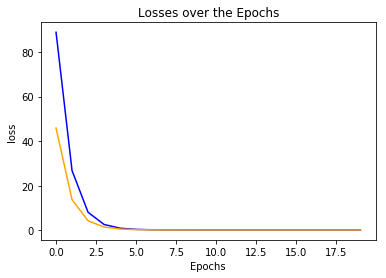

In [29]:
loss_over_epochs(model, add_valid=True)
plt.show()

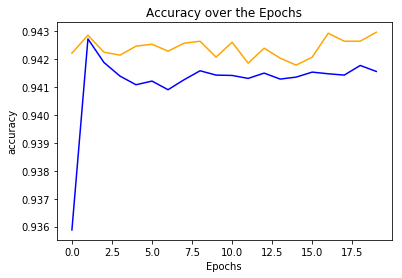

In [30]:
acc_over_epochs(model, add_valid=True)

In [31]:
def save_model(model):
    model_dir=os.path.join("models")
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    model.save(os.path.join(model_dir, "{}_green_img_cnn_reg_stride1.model".format(MAX_IMG_FOR_MODELING)))

In [32]:
score = model.evaluate(test_images, test_labels, batch_size=batch_size)
print(score)

1000/1000 [==============================] - 10s 10ms/step
[0.17611514568328857, 0.9411071329116821]


In [36]:
gc.collect()

13555

### Try random image to classify

In [33]:
# Getting image from the test data

rand_img = test_imgs.reset_index(drop=True).sample(1)
img_idx = rand_img.index.values.tolist()[0]
img_class = test_labels[img_idx]
classes=[]
for k,v in zip(img_class, list(class_names.values())):
    if k:
        classes.append(v)
print(classes)

image=test_images[img_idx]
image = image.reshape(1, 512, 512, 1)

proba = model.predict(image)
proba

['Nucleoplasm', 'Golgi apparatus']


array([[3.4978575e-01, 3.4766052e-02, 1.0230416e-01, 8.8365354e-02,
        7.4488193e-02, 9.3049496e-02, 2.4513746e-02, 8.8460408e-02,
        1.9795455e-03, 1.9231902e-03, 8.7241031e-04, 2.2632781e-02,
        1.7909182e-02, 1.5092271e-02, 2.1094101e-02, 1.0709105e-05,
        1.2091696e-02, 3.5555116e-03, 3.0949932e-02, 5.4444842e-02,
        8.0776485e-03, 7.6223806e-02, 2.5633955e-02, 8.3115913e-02,
        1.4095108e-02, 1.6118602e-01, 1.9638110e-02, 5.2764337e-04]],
      dtype=float32)

In [34]:
pred_cls=[]
for k,v in zip(proba[0], list(class_names.values())):
    if k:
        pred_cls.append(v)
print(pred_cls)

['Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center', 'Nuclear speckles', 'Nuclear bodies', 'Endoplasmic reticulum', 'Golgi apparatus', 'Peroxisomes', 'Endosomes', 'Lysosomes', 'Intermediate filaments', 'Actin filaments', 'Focal adhesion sites', 'Microtubules', 'Microtubule ends', 'Cytokinetic bridge', 'Mitotic spindle', 'Microtubule organizing center', 'Centrosome', 'Lipid droplets', 'Plasma membrane', 'Cell junctions', 'Mitochondria', 'Aggresome', 'Cytosol', 'Cytoplasmic bodies', 'Rods & rings']


In [35]:
import time
first_model_time = time.time()
print((first_model_time - start_time)/60.0)

30.80043246746063


By looking at the accuracy and the loss plots vs epochs, it seems the model is struggling to generalize. If the last 2 cells ran repeatedly most of the time it will give prbablity of the `Neuclioplasm`  higher then any other classes. So it looks like due to unbalanced data it is not generalizing. We'll look at it further in another notebook where more data can be use rather limited here.